In [4]:
import os
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from src.adjacency_matrix import AdjacencyMatrix
from src.experimenter import get_default_params,perform_link_prediction
from src.data_preparer import filter_size, filter_time
from src.utils import print_matrix, _or, get_printable_matrix, get_base_path
from src.vertex import Vertex
from scipy.sparse import csr_matrix
from joblib import Memory
data_path = get_base_path()
cachedir = os.path.join(data_path, 'cache')
memory = Memory(cachedir, verbose=0)

In [3]:
import sys
sys.path.append('../')
from src.utils import get_data_abbr, mkdir_p, get_base_path, get_library_path

library_path = get_library_path()
sys.path.append(library_path)
sys.path.append(os.path.join(library_path, "hynetworkx"))

In [ ]:
# @memory.cache
# def parse_benson_incidence_matrix1(name,base_path=None,split_mode=None,max_size_limit=None,st_time=None,en_time=None):
    
#     ase_path = base_path or DATA_DEFAULTS['base_path_benson']
#     path = os.path.join(base_path, name)  
    
#     try:
#         file_name = os.path.join(path, name + '_native.edges')
#         f = open(file_name, "r")
#         edgelist=[]
#         for line in f:
#             a = int(line.split(' ')[0].strip())  # \t
#             b = int(line.split(' ')[1].strip())
#             if (a!= b):
#                 edge=[a,b]
#                 edgelist.append(edge)
#         graph = nx.Graph()
#         graph.add_edges_from(edgelist)
#         A=nx.adj_matrix(graph)
# #         A=adj
# #         test_pairs = list(zip(*triu(A).nonzero()))
# #         print(len(test_pairs))
#         G = nx.from_scipy_sparse_matrix(A)
#         S=nx.incidence_matrix(G)
#         times=[]
#         for i in range(len(edgelist)):
#             times.append(0)
#         id_label_map={}
#         f.close()
#         return S, np.array(times), id_label_map
    
#     except IOError:
#         nverts_path = os.path.join(path, name + '-nverts.txt')
#         simplices_path = os.path.join(path, name + '-simplices.txt')
#         times_path = os.path.join(path, name + '-times.txt')
#         print('Reading nverts...')
#         nverts = [int(l.rstrip('\n')) for l in tqdm(open(nverts_path, 'r'))]
#         # TODO: Remember that we are reindexing vertices to 0-index.
#         #  This has to be followed while initializing labels as well.
#         print('Reading simplices...')
#         simplices = [int(l.rstrip('\n')) - 1 for l in tqdm(open(simplices_path, 'r'))]
#         labels_path = os.path.join(path, name + '-node-labels.txt')
#         vertices = list(sorted(set(simplices)))
#         n = max(vertices) + 1
#         try:
#             print('Reading labels...')
#             labels = [l.rstrip('\n') for l in tqdm(open(labels_path, 'r'))]
#             labels = [' '.join(l.split(' ')[1:]) for l in labels]
#         except FileNotFoundError:
#             print('No labels found.')
#             labels = ['vertex_{}'.format(i) for i in range(n)]
#         print('Reading times...')
#         times = [float(l.rstrip('\n')) for l in tqdm(open(times_path, 'r'))]
#         hyperedges = set()
#         hyperedge_times_map = defaultdict(set)
#         hyperedge_list = []
#         rows = []
#         cols = []
#         j = 0
#         print('Parsing simplices...')
#         i = 0
#         iterator = list(zip(nverts, times))
#         for nv, time in tqdm(iterator):
#             hyperedge = frozenset(simplices[i: i + nv])
#             hyperedge_times_map[hyperedge].add(time)
#             if hyperedge not in hyperedges:
#                 hyperedges.add(hyperedge)
#                 rows.extend(list(hyperedge))
#                 cols.extend([j] * len(hyperedge))
#                 hyperedge_list.append(hyperedge)
#                 j += 1
#             # else:
#             #     hyperedge_time_map[hyperedge] = min([hyperedge_time_map[hyperedge], time])
#             i += nv
#         m = len(hyperedges)
#         print('Creating sparse matrix...')
#         print(len(rows), len(cols), n, m)
#         S = csr_matrix(([1] * len(rows), (rows, cols)), shape=(n, m))
#         print('Preparing vertex list...')
#         vertex_list = [Vertex(i, labels[i]) for i in tqdm(range(n))]

#         print('Recalculating hyperedge times...')
#         times = np.array([min(hyperedge_times_map[hyperedge_list[j]]) for j in tqdm(range(S.shape[1]))])

#         id_label_map = {v.id: v.label for v in vertex_list}
#         if split_mode == 'structural':
#             min_size_limit = 2
#             print('Filtering size for [{}, {}]'.format(min_size_limit, max_size_limit))
#             S, times = filter_size(S, times, min_size_limit, max_size_limit)

#         S, times, id_label_map = filter_time(S, times, id_label_map, st_time or -1, en_time or -1)

#         if split_mode == 'structural':  # WARNING: DO NOT MOVE THIS FROM HERE; IT HAS TO BE THE LAST STEP
#             times = np.array([0]*times.shape[0])
#             print('WARNING: Time information is defaulted to all zeros (0) since structural mode')
#         print('DATA STATS: S.shape = {}'.format(S.shape))
#         return S, times, id_label_map
    
   
    

In [291]:
params = get_default_params()
# data_name = 'email-Enron'
# data_name = 'contact-high-school'
# data_name = 'NDC-substances'
data_name = 'tags-math-sx'



iiii=2
params['data_params']['max_size_limit']=12

split_mode = 'structural'
params['data_params']['data_name'] = data_name
params['data_params']['split_mode'] = split_mode
dfs = []
i = 0
params['iter_var'] = 2
data_params = params['data_params']
lp_data_params=params['lp_data_params']
lp_params=params['lp_params']

In [292]:
from src.data_preparer import filter_size, prepare_lp_data, get_time_filter_params,incidence_to_hyperedges, S_to_A
from src.incidence_matrix import parse_benson_incidence_matrix as parse_S

data_name, base_path, split_mode, max_size_limit = [data_params[x] for x in
                                                        ['data_name', 'base_path', 'split_mode', 'max_size_limit']]
rho, neg_factor, neg_mode = [lp_data_params[x] for x in['rho', 'neg_factor', 'neg_mode']]
S, times, id_label_map = parse_S(data_name,base_path,split_mode,max_size_limit,
                                                       *get_time_filter_params(data_name))





0it [00:00, ?it/s]

(217219821220, None)
Reading nverts...






75674it [00:00, 756738.92it/s]



153163it [00:00, 762092.93it/s]



227822it [00:00, 757374.54it/s]



305349it [00:00, 762655.50it/s]



383664it [00:00, 768688.93it/s]



461330it [00:00, 771060.50it/s]



533713it [00:00, 756253.43it/s]



619838it [00:00, 784961.47it/s]



704823it [00:00, 803362.88it/s]



822059it [00:01, 777295.65it/s]




0it [00:00, ?it/s]



57936it [00:00, 579353.65it/s]

Reading simplices...






123701it [00:00, 600812.29it/s]



193254it [00:00, 626403.25it/s]



262819it [00:00, 645683.64it/s]



332920it [00:00, 661342.07it/s]



405554it [00:00, 679584.66it/s]



480630it [00:00, 699475.68it/s]



553795it [00:00, 708825.11it/s]



633331it [00:00, 732740.95it/s]



712932it [00:01, 750637.49it/s]



789376it [00:01, 754724.24it/s]



867462it [00:01, 762376.95it/s]



943124it [00:01, 725343.59it/s]



1020324it [00:01, 738735.62it/s]



1094240it [00:01, 696378.74it/s]



1168500it [00:01, 709629.18it/s]



1239895it [00:01, 681909.14it/s]



1316092it [00:01, 704099.83it/s]



1387059it [00:01, 693275.13it/s]



1465934it [00:02, 719398.92it/s]



1546075it [00:02, 742183.71it/s]



1621446it [00:02, 745599.34it/s]



1696407it [00:02, 744349.37it/s]



1801637it [00:02, 716797.77it/s]




1629it [00:00, 640288.75it/s]A




0it [00:00, ?it/s]



73787it [00:00, 737865.43it/s]

Reading labels...
Reading times...






145441it [00:00, 731335.37it/s]



222376it [00:00, 742339.07it/s]



298472it [00:00, 747826.53it/s]



365365it [00:00, 722255.38it/s]



436618it [00:00, 719308.65it/s]



506969it [00:00, 714494.74it/s]



576009it [00:00, 707088.66it/s]



657385it [00:00, 736032.67it/s]



822059it [00:01, 749530.80it/s]




  0%|          | 0/822059 [00:00<?, ?it/s]



  3%|▎         | 28044/822059 [00:00<00:02, 280433.58it/s]

Parsing simplices...






  7%|▋         | 56923/822059 [00:00<00:02, 282887.58it/s]



 10%|█         | 85917/822059 [00:00<00:02, 284965.90it/s]



 14%|█▍        | 116621/822059 [00:00<00:02, 291245.22it/s]



 18%|█▊        | 147693/822059 [00:00<00:02, 296824.06it/s]



 22%|██▏       | 176838/822059 [00:00<00:02, 295191.02it/s]



 25%|██▌       | 208921/822059 [00:00<00:02, 302440.73it/s]



 29%|██▉       | 239188/822059 [00:00<00:01, 302506.97it/s]



 33%|███▎      | 269069/822059 [00:00<00:01, 301384.91it/s]



 36%|███▋      | 298112/822059 [00:01<00:01, 295013.07it/s]



 40%|███▉      | 328244/822059 [00:01<00:01, 296876.29it/s]



 44%|████▎     | 358464/822059 [00:01<00:01, 298451.16it/s]



 47%|████▋     | 389807/822059 [00:01<00:01, 302791.75it/s]



 51%|█████     | 419852/822059 [00:01<00:01, 292313.55it/s]



 55%|█████▍    | 448998/822059 [00:01<00:01, 286712.58it/s]



 58%|█████▊    | 477715/822059 [00:01<00:01, 286107.11it/s]



 62%|██████▏   | 508608/822059 [00:01<00:01, 292590.7

Creating sparse matrix...
593121 593121 1629 170476
Preparing vertex list...
Recalculating hyperedge times...






 28%|██▊       | 47843/170476 [00:00<00:01, 92678.77it/s]



 64%|██████▍   | 109486/170476 [00:00<00:00, 124383.60it/s]



100%|██████████| 170476/170476 [00:00<00:00, 419731.52it/s]


Filtering size for [2, 12]
Filtering time for [217219821220, 234102455203.0]
DATA STATS: S.shape = (1554, 22274)


In [293]:
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix
import numpy as np
import math
from tqdm import tqdm_notebook
from scipy.sparse import triu, spdiags
from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')

def S_to_A(S, weighted, silent=True):
    if not silent:
        print('Converting S to A')
        print('STEP 1: Computing SS^T')
    A = S * S.T

    if weighted == False:
        if not silent:
            print('STEP 2: Binarizing A')
        A[A > 0] = 1
    if not silent:
        print('STEP 3: Setting diagonals to 0')
    A.setdiag(0)
    if not silent:
        print('STEP 4: Eliminating zeros')
    A.eliminate_zeros()
    return A

def get_dd_cnd(A):
    dd = A.diagonal()
#     A_pos=pos_edges(A,0.002, mode='random')
    print("1a")
    A_pos=A
    A_neg=neg_edges(A,A_pos,5, mode='random') 
    print("1b")
    I,J = zip(*(list(zip(*triu(A_pos).nonzero())) + list(zip(*triu(A_neg).nonzero()))))
    print("1c")
    cnd = np.ravel(A[I, J])
    file = open(data_name+'_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'wb')
    pickle.dump(cnd, file)
    file.close()
    return dd, cnd

def get_cond_cnd(A, A_CN):
    dd = A_CN.diagonal()   
#     A_pos=pos_edges(A,0.002, mode='random')
    A_pos=A
    A_neg=neg_edges(A,A_pos,5, mode='random')
    I_linked, J_linked = triu(A_pos).nonzero()
    IJ_linked = set(zip(I_linked, J_linked)) 
    I_unlinked, J_unlinked = triu(A_neg).nonzero()
    IJ_unlinked = set(zip(I_unlinked, J_unlinked)) 
#     I,J = zip(*(list(zip(*triu(A_pos).nonzero())) + list(zip(*triu(A_neg).nonzero()))))
#     IJ = set(zip(I, J))
#     print(len(IJ),len(IJ_linked))
    linked_cnd = np.ravel(A_CN[I_linked, J_linked])
    try:
#         I_unlinked, J_unlinked = zip(*[x for x in IJ if x not in IJ_linked])
        unlinked_cnd = np.ravel(A_CN[I_unlinked, J_unlinked])
    except ValueError: # if no unlinked pair
        print('ERROR: No unlinked pair!')
        unlinked_cnd = None
    file = open(data_name+'_linked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'wb')
    pickle.dump(linked_cnd, file)
    file.close()
    file = open(data_name+'_unlinked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'wb')
    pickle.dump(unlinked_cnd, file)
    file.close()
    return linked_cnd, unlinked_cnd

def formulate_table_hypergraph_real(S):
    A = S_to_A(S, False)
    A_CN = A.astype(int)**2
    print("1")
    dd, cnd = get_dd_cnd(A_CN)
    print("2")
    linked_cnd, unlinked_cnd = get_cond_cnd(A, A_CN)
    print("3")

    # print(linked_cnd2)
    # print(unlinked_cnd2)
    est_mean = np.mean(cnd)
    est_var = np.var(cnd)
    est_prob = est_mean / (S.shape[0]-2)

    est_mean_linked = np.mean(linked_cnd)
    est_var_linked = np.var(linked_cnd)
    est_prob_linked = est_mean_linked / (S.shape[0]-2)

    est_mean_unlinked = 0 if unlinked_cnd is None else np.mean(unlinked_cnd)
    est_var_unlinked = 0 if unlinked_cnd is None else np.var(unlinked_cnd)
    est_prob_unlinked = est_mean_unlinked / (S.shape[0]-2)
    p_H=0
    return(p_H,est_mean,est_var,est_prob,est_mean_linked,est_var_linked,est_prob_linked,est_mean_unlinked,est_var_unlinked,est_prob_unlinked)


In [294]:
# dict_hypergraph_real={}
    # print(n,p,s)

h_p,est_mean,est_var,est_prob,est_mean_linked,est_var_linked,est_prob_linked,est_mean_unlinked,est_var_unlinked,est_prob_unlinked  = formulate_table_hypergraph_real(S)
var=(data_name,split_mode)
dict_hypergraph_real[var]={'h_p':h_p,'estimated_mean':est_mean,'estimated_var':est_var,'estimated_prob':est_prob,'est_mean_linked':est_mean_linked,'est_var_linked':est_var_linked,
             'est_prob_linked':est_prob_linked,'est_mean_unlinked':est_mean_unlinked,'est_var_unlinked':est_var_unlinked,'est_prob_unlinked':est_prob_unlinked}
dict_hypergraph_real


1
1a
Cannot generate 8006480 negative samples; generating 812066.0
1b
1c






  0%|          | 0/189775 [00:00<?, ?it/s]



  1%|          | 1224/189775 [00:00<00:15, 12239.87it/s]

2






  1%|          | 2214/189775 [00:00<00:16, 11427.83it/s]



  2%|▏         | 3283/189775 [00:00<00:16, 11194.76it/s]



  2%|▏         | 4392/189775 [00:00<00:16, 11160.43it/s]



  3%|▎         | 5497/189775 [00:00<00:16, 11126.51it/s]



  4%|▎         | 6659/189775 [00:00<00:16, 11268.29it/s]



  4%|▍         | 7851/189775 [00:00<00:15, 11454.76it/s]



  5%|▍         | 8899/189775 [00:00<00:16, 11141.56it/s]



  5%|▌         | 10083/189775 [00:00<00:15, 11340.72it/s]



  6%|▌         | 11216/189775 [00:01<00:15, 11336.09it/s]



  7%|▋         | 12424/189775 [00:01<00:15, 11549.27it/s]



  7%|▋         | 13558/189775 [00:01<00:15, 11334.73it/s]



  8%|▊         | 14678/189775 [00:01<00:15, 11235.02it/s]



  8%|▊         | 15865/189775 [00:01<00:15, 11417.86it/s]



  9%|▉         | 17001/189775 [00:01<00:15, 11116.56it/s]



 10%|▉         | 18111/189775 [00:01<00:16, 10272.97it/s]



 10%|█         | 19150/189775 [00:01<00:17, 9607.40it/s] 



 11%|█         | 20197/1897

 68%|██████▊   | 128577/189775 [00:11<00:05, 10393.07it/s]



 68%|██████▊   | 129623/189775 [00:11<00:05, 10191.53it/s]



 69%|██████▉   | 130719/189775 [00:12<00:05, 10409.31it/s]



 69%|██████▉   | 131821/189775 [00:12<00:05, 10582.94it/s]



 70%|███████   | 132973/189775 [00:12<00:05, 10844.41it/s]



 71%|███████   | 134062/189775 [00:12<00:05, 10712.52it/s]



 71%|███████   | 135185/189775 [00:12<00:05, 10860.40it/s]



 72%|███████▏  | 136274/189775 [00:12<00:04, 10721.08it/s]



 72%|███████▏  | 137349/189775 [00:12<00:04, 10616.56it/s]



 73%|███████▎  | 138418/189775 [00:12<00:04, 10634.28it/s]



 73%|███████▎  | 139483/189775 [00:12<00:04, 10595.43it/s]



 74%|███████▍  | 140544/189775 [00:12<00:04, 10481.00it/s]



 75%|███████▍  | 141594/189775 [00:13<00:04, 10324.52it/s]



 75%|███████▌  | 142684/189775 [00:13<00:04, 10489.52it/s]



 76%|███████▌  | 143745/189775 [00:13<00:04, 10523.88it/s]



 76%|███████▋  | 144823/189775 [00:13<00:04, 10596.24it/s]



 77%|███

3


{('email-Enron', 'structural'): {'h_p': 0,
  'estimated_mean': 4.204790853824517,
  'estimated_var': 35.978294804728975,
  'estimated_prob': 0.028799937354962446,
  'est_mean_linked': 13.111888111888112,
  'est_var_linked': 46.103183529756954,
  'est_prob_linked': 0.08980745282115145,
  'est_mean_unlinked': 2.414367450731087,
  'est_var_unlinked': 11.17566134495453,
  'est_prob_unlinked': 0.016536763361171828},
 ('contact-high-school', 'structural'): {'h_p': 0,
  'estimated_mean': 4.524371596926978,
  'estimated_var': 50.79803733726442,
  'estimated_prob': 0.013921143375159933,
  'est_mean_linked': 17.645238913716053,
  'est_var_linked': 86.17184137468372,
  'est_prob_linked': 0.05429304281143401,
  'est_mean_unlinked': 2.691130972842901,
  'est_var_unlinked': 14.125466201134184,
  'est_prob_unlinked': 0.008280402993362773},
 ('NDC-substances', 'structural'): {'h_p': 0,
  'estimated_mean': 0.9426430395258368,
  'estimated_var': 26.57972587185755,
  'estimated_prob': 0.00016972326963014

In [295]:
file = open('dict_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'wb')
pickle.dump(dict_hypergraph_real, file)
file.close()

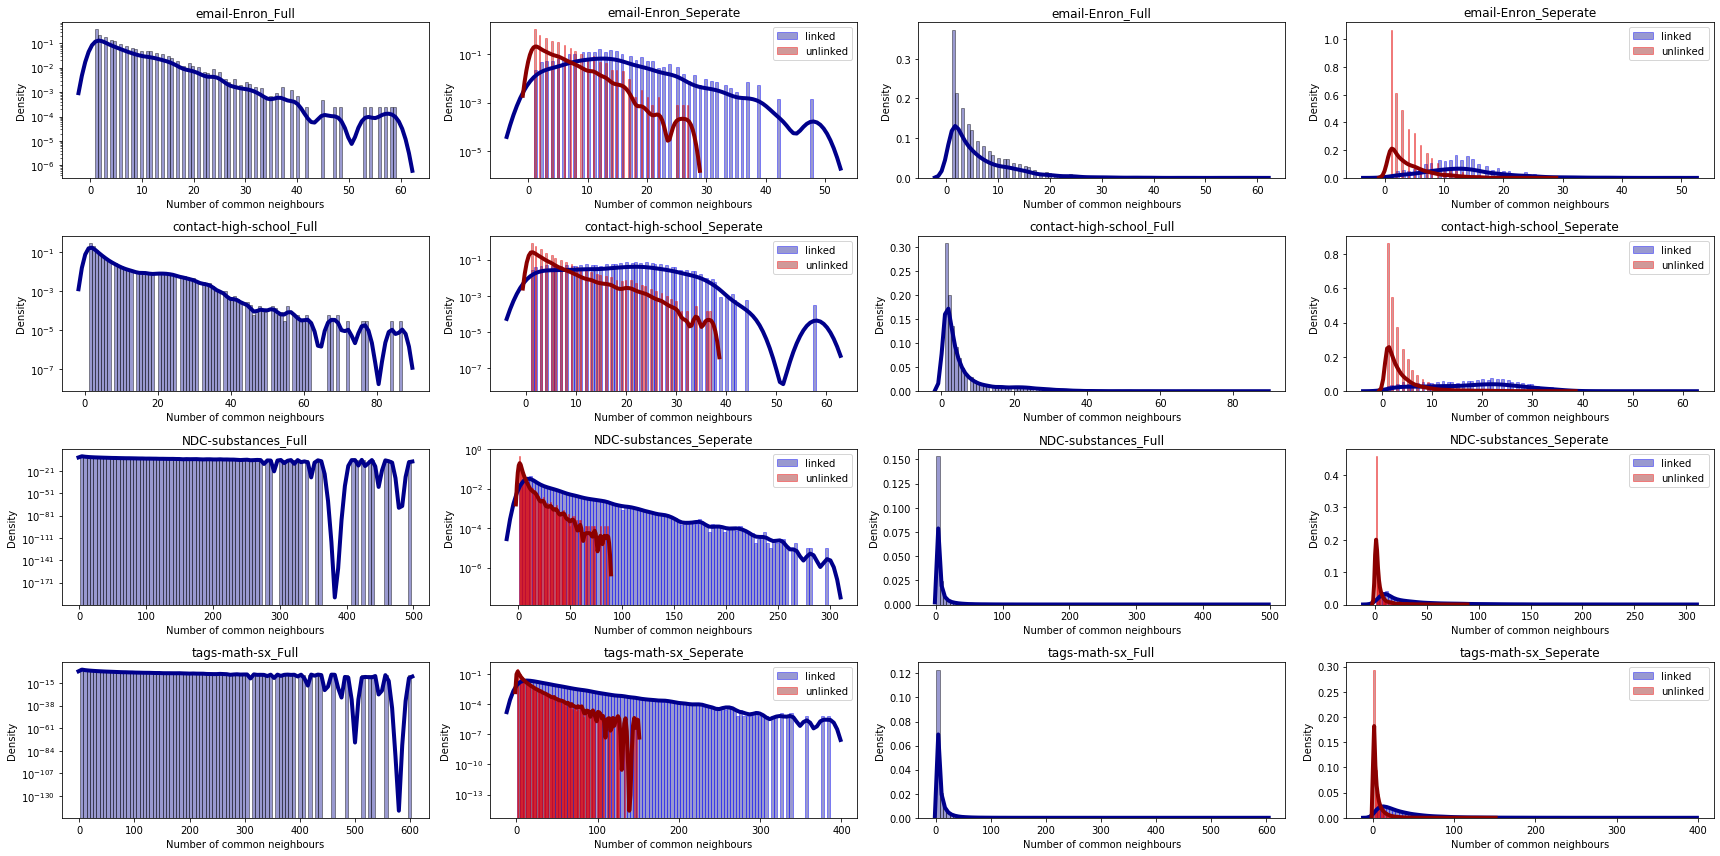

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns
data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx']
whats=['cnd','linked_cnd','unlinked_cnd']
fig, axs = plt.subplots(len(data_names), 2*(len(whats)-1), figsize = (6*len(data_names), 6*(len(whats)-1)), sharey=False)

for i,data_name in enumerate(data_names):
#     for j,what in enumerate(whats):
        j = 0
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
        
        ax = axs[i][j] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                    ax=ax)
        ax.set_yscale('log')
        ax.set_xlabel('Number of common neighbours')
        ax.set_ylabel('Density')
        ax.set_title(data_name +'_Full')
        j = 1
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
        ax = axs[i][j] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'blue'},
             kde_kws={'linewidth': 4},
                    ax=ax,
                    label=what.split('_')[0])
        
        j = 2
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
#         ax = axs[i][j] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkred', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4},
                    ax=ax,
                    label=what.split('_')[0])
        ax.legend()
        ax.set_yscale('log')
        ax.set_xlabel('Number of common neighbours')
        ax.set_ylabel('Density')
        ax.set_title(data_name + '_Seperate')
        
#         ax.hist(nz_data, bins=100, density=True)
#         plt.plot(kind='line', ax = ax)
        
#         plt.show()



        j = 0
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
        
        ax = axs[i][2] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                    ax=ax)
#         ax.set_yscale('log')
        ax.set_xlabel('Number of common neighbours')
        ax.set_ylabel('Density')
        ax.set_title(data_name +'_Full')
        j = 1
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
        ax = axs[i][3] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'blue'},
             kde_kws={'linewidth': 4},
                    ax=ax,
                    label=what.split('_')[0])
        
        j = 2
        what = whats[j]
        file = open(data_name +'_'+ what+'_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
        data = pickle.load(file)
        nz_data = data[data>0]
        file.close()
#         ax = axs[i][j] if len(data_names) > 1 and len(whats) > 1 else (axs[i] if len(data_names) > 1 else axs[j])
        sns.distplot(nz_data, hist=True, kde=True, 
             bins=100, color = 'darkred', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4},
                    ax=ax,
                    label=what.split('_')[0])
        ax.legend()
#         ax.set_yscale('log')
        ax.set_xlabel('Number of common neighbours')
        ax.set_ylabel('Density')
        ax.set_title(data_name + '_Seperate')
    
plt.tight_layout()
plt.savefig('case_' + str(iiii)+'_'+str(params['data_params']['max_size_limit'])  + '.png')


In [ ]:
def pos_edges(A,ratio, mode='random'):
    n = A.shape[0]
    edge_count = triu(A).nnz
    desired_pos_count = int(ratio * edge_count)
    pos_count = 0
    A_pos = csr_matrix(A.shape, dtype=int)
    pos_pairs = set()
    pbar = tqdm(total=desired_pos_count)
    I, J = [], []
    while pos_count < desired_pos_count:
        u, v = get_random_pair(n)
        u, v = (u, v) if u <= v else (v, u)
        if A[u, v] and (u, v) not in pos_pairs:
            I.extend([u, v])
            J.extend([v, u])
            pos_pairs.add((u, v))
            pos_count += 1
            pbar.update(1)
    pbar.close()
    A_pos = csr_matrix(([1] * len(I), (I, J)), shape=A.shape)
    return(A_pos)

In [88]:
def get_random_pair(n):
    u = random.randrange(n)
    while True:
        v = random.randrange(n)
        if u != v:
            return (u, v)
        
def neg_edges(A,A_pos,factor, mode='random'):
    n = A.shape[0]
    edge_count = triu(A_pos).nnz
    
    pos_count = triu(A_pos).nnz
    max_neg_count = (n ** 2 - n) / 2 - edge_count
    if factor > 0:
        desired_neg_count = int(factor * edge_count)
    else:
        desired_neg_count = max_neg_count + 1
    if max_neg_count < desired_neg_count:
        print('Cannot generate {} negative samples; generating {}'.format(2 * desired_neg_count, 2 * max_neg_count))
        A_neg = csr_matrix(A.shape, dtype=int)
        A_neg[A == 0] = 1
        A_neg.setdiag(0)
        A_neg.eliminate_zeros()
        return(A_neg)

    else:     
        neg_count = 0
        A_neg = csr_matrix(A.shape, dtype=int)
        neg_pairs = set()
        pbar = tqdm(total=desired_neg_count)
        I, J = [], []
        while neg_count < desired_neg_count:
            u, v = get_random_pair(n)
            u, v = (u, v) if u <= v else (v, u)
            if not A[u, v] and (u, v) not in neg_pairs:
                I.extend([u, v])
                J.extend([v, u])
                neg_pairs.add((u, v))
                neg_count += 1
                pbar.update(1)
        pbar.close()
        A_neg = csr_matrix(([1] * len(I), (I, J)), shape=A.shape)
        return(A_neg)
import random
import pickle



In [ ]:
A = S_to_A(S, False)
print(A.sum())
A_pos=pos_edges(A,0.2, mode='random')
print(A_pos.sum())
A_neg=neg_edges(A,A_pos,5, mode='random')
print(A_neg.sum())

In [297]:
df_H = pd.DataFrame(dict_hypergraph).T.reset_index().rename(columns = {'level_0': 'n', 'level_1': 'p_G', 'level_2': 's', 'h_p': 'p_s',
                                                                'estimated_mean': 'mu', 'estimated_var': 'var', 'estimated_prob': 'p_CN',
                                                                'est_mean_linked': 'mu_l', 'est_var_linked': 'var_l', 'est_prob_linked': 'p_CN_l',
                                                                'est_mean_unlinked': 'mu_ul', 'est_var_unlinked': 'var_ul', 'est_prob_unlinked': 'p_CN_ul',})
# fig, axs = plt.subplots(len(total_n), len(total_s), figsize = (6*len(total_s), 6*len(total_n)), sharey=False)

# for i, n in enumerate(total_n):
#     for j, s in enumerate(total_s):
#         ax = axs[i][j] if len(total_n) > 1 and len(total_s) > 1 else (axs[i] if len(total_n) > 1 else axs[j])
        df1 = df_H[(df_H['n'] == n) & (df_H['s'] == s)]
        df1['var'] = df1['var'].apply(np.sqrt)
        df1['var_l'] = df1['var_l'].apply(np.sqrt)
        df1['var_ul'] = df1['var_ul'].apply(np.sqrt)
        
        # df1[['p_G', 'mu', 'mu_l', 'mu_ul']].plot(x='p_G', kind='line', title='n={}, s={}'.format(n, s), ax = ax)
        df1[['p_G', 'var', 'var_l', 'var_ul']].plot(x='p_G', kind='line', title='n={}, s={}'.format(n, s), ax = ax)
        df1['d_mu_l'] = df1['mu_l'] - df1['mu']
        df1['d_mu_ul'] = df1['mu'] - df1['mu_ul']
        # df1[['p_G', 'd_mu_l', 'd_mu_ul']].plot(x='p_G', kind='line', title='n={}, s={}'.format(n, s), ax = ax)
        
        # ax.errorbar('p_G', 'mu', yerr='var', data=df1, label='all', capsize=5)
        # ax.errorbar('p_G', 'mu_l', yerr='var_l', data=df1, label='l', capsize=5)
        # ax.errorbar('p_G', 'mu_ul', yerr='var_ul', data=df1, label='ul', capsize=5)
        # ax.legend()
        ax.set_title('n={}, s={}'.format(n, s))
        # ax.set_ylabel('')?
        ax.grid()
plt.tight_layout()

IndentationError: unexpected indent (<ipython-input-297-74e80e5932ab>, line 10)

In [ ]:
weighted_lp_data,lp_results = perform_link_prediction(params['data_params'], params['lp_data_params'],
                                        params['lp_params'],params['iter_var'])

In [ ]:
import seaborn as sns; sns.set()
from experimenter import *
from utils import *
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm_notebook
from tabulate import tabulate
mcm = mixed_combinations_map
if 'HDPa' in mcm['PA']:
    mcm['PA'].remove('HDPa')
scores_df=lp_results['scores']
required_x=scores_df[['AA']]
required_y=scores_df[['HAAl1']]
required_x[required_x!=0].dropna()

In [ ]:
import seaborn as sns
for c in mcm['AA'][3:4]:
    scores = scores_df[scores_df[c] > 0][c].copy(deep=True)
    labels = scores_df[scores_df[c] > 0]['label'].copy(deep=True)
    _max = scores.max()
    _min = scores.min()
    scores = (scores - _min)/(_max - _min)
    pos = scores[labels==1].dropna()
    neg = scores[labels==0].dropna()
    lm = sns.distplot(pos, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    lm = sns.distplot(neg, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
lm.axes.set_xlim(0,)

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
plt.figure()
for c in mcm['PA']:
    fpr, tpr, _ = roc_curve(scores_df['label'], scores_df[c])
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve for {} (area = {})'.format(c, round(roc_auc, 2)))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()